In [1]:
import os
import os.path
import random
import gc
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
sns.set()

In [5]:
import pickle

def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

## Read Data

In [6]:
DATA_DIR = '../input/msci-multi-mlp-tsvd'
%ls $DATA_DIR -lh

total 5.0G
-rw-r--r-- 1 nobody nogroup  19K Nov  4 12:17 __notebook__.ipynb
-rw-r--r-- 1 nobody nogroup 6.1K Nov  4 12:17 __output__.json
-rw-r--r-- 1 nobody nogroup 286K Nov  4 12:17 __results__.html
-rw-r--r-- 1 nobody nogroup    0 Nov  4 12:17 custom.css
-rw-r--r-- 1 nobody nogroup 1.8G Nov  4 12:17 test_inp
-rw-r--r-- 1 nobody nogroup 3.3G Nov  4 12:18 train_inp


In [7]:
%%time
train_inp = load_pickle(f'{DATA_DIR}/train_inp')
train_inp.shape

CPU times: user 1.29 s, sys: 8.7 s, total: 9.98 s
Wall time: 37.3 s


(105942, 8192)

In [8]:
DATA_DIR = '../input/open-problems-multimodal'
%ls $DATA_DIR -lh

total 27G
-rw-r--r-- 1 nobody nogroup 2.3G Sep  7 19:44 evaluation_ids.csv
-rw-r--r-- 1 nobody nogroup 9.4M Sep  7 19:43 metadata.csv
-rw-r--r-- 1 nobody nogroup 230K Sep  7 19:43 metadata_cite_day_2_donor_27678.csv
-rw-r--r-- 1 nobody nogroup 805M Sep  7 19:43 sample_submission.csv
-rw-r--r-- 1 nobody nogroup 1.6G Sep  7 19:44 test_cite_inputs.h5
-rw-r--r-- 1 nobody nogroup 294M Sep  7 19:43 test_cite_inputs_day_2_donor_27678.h5
-rw-r--r-- 1 nobody nogroup 6.1G Sep  7 19:45 test_multi_inputs.h5
-rw-r--r-- 1 nobody nogroup 2.4G Sep  7 19:44 train_cite_inputs.h5
-rw-r--r-- 1 nobody nogroup  37M Sep  7 19:43 train_cite_targets.h5
-rw-r--r-- 1 nobody nogroup  11G Sep  7 19:46 train_multi_inputs.h5
-rw-r--r-- 1 nobody nogroup 3.0G Sep  7 19:45 train_multi_targets.h5


In [9]:
%%time
train_tar = pd.read_hdf(f'{DATA_DIR}/train_multi_targets.h5')
train_tar.shape

CPU times: user 57.5 s, sys: 14 s, total: 1min 11s
Wall time: 1min 36s


(105942, 23418)

In [10]:
train_tar = train_tar.values

## Modeling

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

In [12]:
%%time
train_inp = torch.from_numpy(train_inp)
train_tar = torch.from_numpy(train_tar)

CPU times: user 27 µs, sys: 9 µs, total: 36 µs
Wall time: 40.3 µs


In [13]:
full_ds = TensorDataset(train_inp, train_tar)
train_sz = 84992
val_sz = len(full_ds) - train_sz
train_ds, val_ds = random_split(full_ds, 
                                [train_sz, val_sz],
                                generator=torch.Generator().manual_seed(42))

In [14]:
batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [15]:
class Net(nn.Module):
    def __init__(self):
        """In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
        self.linear1 = nn.Linear(8192, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.linear3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.linear4 = nn.Linear(128, 23418)


    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.linear4(x)
        x = F.relu(x)

        return x

In [16]:
def train_model(train_loader, model, optimizer):
    
    model.train()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(train_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        total += batch
        sum_corr += batch * corr
    
    train_corr = sum_corr/total 
    return train_corr

In [17]:
def model_eval(model, val_loader):
    model.eval()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(val_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        total += batch
        sum_corr += batch * corr
        
    val_corr = sum_corr/total
    return val_corr

In [18]:
# res = []
# lrs = [0.01, 0.001, 0.0001, 0.00001]
# wds = [0.1, 0.01]
# epochs = 15

# for learning_rate in lrs:
#     for weight_decay in wds:
#         print('------')
#         print(f'learning rate: {learning_rate}')
#         print(f'weight decay: {weight_decay}')
#         print()
        
#         net = Net()
#         optimizer = optim.Adam(net.parameters(),
#                     lr=learning_rate,
#                     weight_decay=weight_decay)
        
#         train_corrs = []
#         val_corrs = []
        
#         for epoch in range(epochs):
#             # train
#             print('epoch', epoch)
#             train_corr = train_model(train_loader, net, optimizer)
#             train_corr = float(train_corr.detach().numpy())
#             train_corrs.append(train_corr)
#             print(f'train corr: {train_corr:.4f}')

#             # val
#             val_corr = model_eval(net, val_loader)
#             val_corr = float(val_corr.detach().numpy())
#             val_corrs.append(val_corr)
#             print(f'val corr: {val_corr:.4f}')
#             print()
        
#         res.append([train_corrs, val_corrs, 
#                     learning_rate, weight_decay])   
        
# del net, train_corrs, val_corrs
# gc.collect()

In [19]:
# figsize(8, 16)
# for i in range(8):
#     train_corrs, val_corrs, learning_rate, weight_decay = res[i]
#     print('------')
#     print(f'learning rate: {learning_rate}')
#     print(f'weight decay: {weight_decay}')
#     print(f'best score on val set: {np.max(val_corrs):.4f}')
#     print()
    
#     plt.subplot(4, 2, i+1)
#     plt.scatter(list(range(epochs)), 
#                 train_corrs, 
#                 label='training corr')
#     plt.plot(list(range(epochs)), 
#              train_corrs)
#     plt.scatter(list(range(epochs)), 
#                 val_corrs, 
#                 label='val corr')
#     plt.plot(list(range(epochs)), 
#              val_corrs)
#     plt.legend(loc='lower right')
#     plt.title(f'lr = {learning_rate} | wd = {weight_decay}')
#     plt.ylim(0.5, 1)
# plt.tight_layout()

# del train_corrs, val_corrs
# gc.collect()

In [20]:
net = Net()
learning_rate = 0.001
weight_decay = 0.01 
optimizer = optim.Adam(net.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

In [21]:
%%time
epochs = 30
train_corrs = []
val_corrs = []
best_val_corr = 0.0
best_epoch = 0

for epoch in range(epochs):
    # train
    print('epoch', epoch)
    train_corr = train_model(train_loader, net, optimizer)
    train_corr = float(train_corr.detach().numpy())
    train_corrs.append(train_corr)
    print(f'train corr: {train_corr:.4f}')
    
    # val
    val_corr = model_eval(net, val_loader)
    val_corr = float(val_corr.detach().numpy())
    val_corrs.append(val_corr)
    print(f'val corr: {val_corr:.4f}')
    print()
    
    # early stoppage
#     if epoch - best_epoch > 3:
#         if val_corr < best_val_corr:
#             print(f'**Early Stoppage** We are stopping at epoch {epoch}...')
#             print(f'Best epoch: epoch {best_epoch}')
#             print(f'Best val correlation: {val_corr: .4f}')
#             break
            
#     # update
#     if val_corr > best_val_corr:
#         best_val_corr = max([best_val_corr, val_corr])
#         best_epoch = epoch
# #         print(epoch, best_epoch, best_val_corr)
# #         print()

epoch 0
train corr: 0.4855
val corr: 0.6286

epoch 1
train corr: 0.6371
val corr: 0.6396

epoch 2
train corr: 0.6424
val corr: 0.6445

epoch 3
train corr: 0.6457
val corr: 0.6462

epoch 4
train corr: 0.6478
val corr: 0.6462

epoch 5
train corr: 0.6497
val corr: 0.6496

epoch 6
train corr: 0.6520
val corr: 0.6522

epoch 7
train corr: 0.6536
val corr: 0.6529

epoch 8
train corr: 0.6542
val corr: 0.6536

epoch 9
train corr: 0.6544
val corr: 0.6533

epoch 10
train corr: 0.6542
val corr: 0.6531

epoch 11
train corr: 0.6541
val corr: 0.6533

epoch 12
train corr: 0.6539
val corr: 0.6530

epoch 13
train corr: 0.6540
val corr: 0.6530

epoch 14
train corr: 0.6541
val corr: 0.6532

epoch 15
train corr: 0.6542
val corr: 0.6531

epoch 16
train corr: 0.6543
val corr: 0.6536

epoch 17
train corr: 0.6543
val corr: 0.6536

epoch 18
train corr: 0.6545
val corr: 0.6537

epoch 19
train corr: 0.6545
val corr: 0.6539

epoch 20
train corr: 0.6546
val corr: 0.6536

epoch 21
train corr: 0.6546
val corr: 0.6538

(0.0, 1.0)

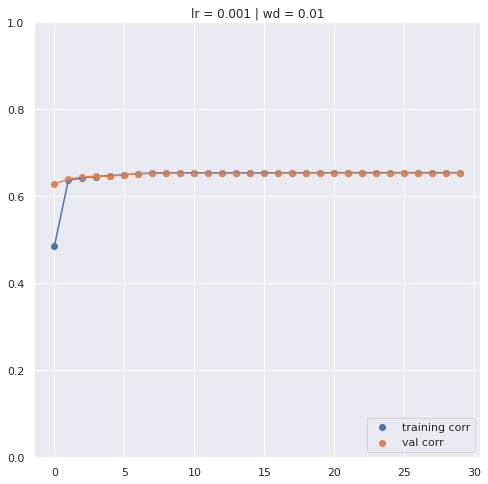

In [22]:
figsize(8, 8)
plt.scatter(list(range(epochs)), train_corrs, label='training corr')
plt.plot(list(range(epochs)), train_corrs)
plt.scatter(list(range(epochs)), val_corrs, label='val corr')
plt.plot(list(range(epochs)), val_corrs)
plt.legend(loc='lower right')
plt.title(f'lr = {learning_rate} | wd = {weight_decay}')
plt.ylim(0, 1)

In [23]:
del train_inp, train_tar, full_ds
gc.collect()

3424

## Prediction

In [24]:
DATA_DIR = '../input/msci-multi-mlp-tsvd'
%ls $DATA_DIR -lh

total 5.0G
-rw-r--r-- 1 nobody nogroup  19K Nov  4 12:17 __notebook__.ipynb
-rw-r--r-- 1 nobody nogroup 6.1K Nov  4 12:17 __output__.json
-rw-r--r-- 1 nobody nogroup 286K Nov  4 12:17 __results__.html
-rw-r--r-- 1 nobody nogroup    0 Nov  4 12:17 custom.css
-rw-r--r-- 1 nobody nogroup 1.8G Nov  4 12:17 test_inp
-rw-r--r-- 1 nobody nogroup 3.3G Nov  4 12:18 train_inp


In [25]:
%%time
test_inp = load_pickle(f'{DATA_DIR}/test_inp')
test_inp = torch.from_numpy(test_inp)

CPU times: user 801 ms, sys: 9.34 s, total: 10.1 s
Wall time: 28.7 s


In [26]:
with torch.no_grad():
    net.eval()
    test_tar_preds = net(test_inp).detach().numpy()

In [27]:
del test_inp
gc.collect()

84

## Creating Submission

In [28]:
DATA_DIR = '../input/msci-h5-sparse-transform'
%ls $DATA_DIR -lh

total 7.1G
-rw-r--r-- 1 nobody nogroup  25K Oct 25 09:30 __notebook__.ipynb
-rw-r--r-- 1 nobody nogroup  25K Oct 25 09:30 __output__.json
-rw-r--r-- 1 nobody nogroup 293K Oct 25 09:30 __results__.html
-rw-r--r-- 1 nobody nogroup    0 Oct 25 09:30 custom.css
-rw-r--r-- 1 nobody nogroup 359M Oct 25 09:30 evaluation_ids.parquet
-rw-r--r-- 1 nobody nogroup 3.8M Oct 25 09:30 metadata.parquet
-rw-r--r-- 1 nobody nogroup 108K Oct 25 09:30 metadata_cite_day_2_donor_27678.parquet
-rw-r--r-- 1 nobody nogroup 252M Oct 25 09:30 sample_submission.parquet
-rw-r--r-- 1 nobody nogroup 856K Oct 25 09:30 test_cite_inputs_day_2_donor_27678_idx.npz
-rw-r--r-- 1 nobody nogroup  78M Oct 25 09:30 test_cite_inputs_day_2_donor_27678_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 1.8M Oct 25 09:30 test_cite_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 488M Oct 25 09:31 test_cite_inputs_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 8.4M Oct 25 09:30 test_multi_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 1.7G Oct 25 09:31 

In [29]:
test_tar_cols = np.load(f'{DATA_DIR}/train_multi_targets_idx.npz',
                        allow_pickle=True)['columns']
test_tar_idx = np.load(f'{DATA_DIR}/test_multi_inputs_idx.npz',
                       allow_pickle=True)['index']
test_tar_cols.shape, test_tar_idx.shape, test_tar_preds.shape

((23418,), (55935,), (55935, 23418))

In [30]:
%%time
print('Start Eval...')
eval_ids = pd.read_parquet(f'{DATA_DIR}/evaluation_ids.parquet')
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

Start Eval...
CPU times: user 34.1 s, sys: 9.46 s, total: 43.6 s
Wall time: 40 s


In [31]:
%%time
sub = pd.Series(name='target',
                index=pd.MultiIndex.from_frame(eval_ids), 
                dtype=np.float32)
sub

CPU times: user 24.7 s, sys: 6.29 s, total: 30.9 s
Wall time: 31 s


row_id    cell_id       gene_id        
0         c2150f55becb  CD86              NaN
1         c2150f55becb  CD274             NaN
2         c2150f55becb  CD270             NaN
3         c2150f55becb  CD155             NaN
4         c2150f55becb  CD112             NaN
                                           ..
65744175  2c53aa67933d  ENSG00000134419   NaN
65744176  2c53aa67933d  ENSG00000186862   NaN
65744177  2c53aa67933d  ENSG00000170959   NaN
65744178  2c53aa67933d  ENSG00000107874   NaN
65744179  2c53aa67933d  ENSG00000166012   NaN
Name: target, Length: 65744180, dtype: float32

In [32]:
cell_id_dict = {cell_id: idx 
                for idx, cell_id in enumerate(test_tar_idx, 0)}
gene_id_dict = {gene_id: idx 
                for idx, gene_id in enumerate(test_tar_cols, 0)}

In [33]:
eid_cid_idx = eval_ids['cell_id']\
              .apply(lambda x: cell_id_dict.get(x, -1))
eid_gid_idx = eval_ids['gene_id']\
              .apply(lambda x: gene_id_dict.get(x, -1))
valid_multi_rows = (eid_cid_idx != -1) & (eid_gid_idx != -1)

In [34]:
%%time
sub.iloc[valid_multi_rows] = test_tar_preds\
                             [eid_cid_idx[valid_multi_rows].to_numpy(),
                              eid_gid_idx[valid_multi_rows].to_numpy()]

CPU times: user 1.88 s, sys: 2.03 s, total: 3.92 s
Wall time: 3.94 s


In [35]:
del eval_ids, test_tar_idx, test_tar_cols
del eid_cid_idx, eid_gid_idx, valid_multi_rows
gc.collect()

97

In [36]:
sub = pd.DataFrame(sub).fillna(0).reset_index()
sub.drop(['cell_id', 'gene_id'], axis=1)\
   .to_csv('multi_sub.csv', index=False)

In [37]:
sub.tail()

,row_id,cell_id,gene_id,target
65744175,65744175,2c53aa67933d,ENSG00000134419,0.011557
65744176,65744176,2c53aa67933d,ENSG00000186862,0.000000
65744177,65744177,2c53aa67933d,ENSG00000170959,0.000000
65744178,65744178,2c53aa67933d,ENSG00000107874,0.002184
65744179,65744179,2c53aa67933d,ENSG00000166012,0.008486
